# Lab 6: Blood Pressure

The goal of this lab is to create and test a band pass filter to isolate a patient's pulse while taking his or her blood pressure. The blood pressure apparatus works by pressuring a band around the patient's arm higher than his or her blood pressure, temporarily cutting off blood flow. The pressure is slowly released and monitored on the output of the band. As the pressure drops below the patient's blood pressure, the blood will start flowing, and the pulse creates visible ripples in the pressure data. This pulse is what is going to be isolated by the band pass filter.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Hardware Setup

![Hardware Schematic](lab6_schematic.png)

A hardware band pass filter was created to filter out the pressure of the bad and the high-frequency noise generated by the power supply. Contrary to what was suggested in the lab, a first-order high pass filter was used and a second-order low pass filter was used, as experimentally, it filtered the data much more precisely.

The cutoff frequencies were set to 0.201 Hz for the high pass filter and 2.27 Hz and 1.59 Hz for the low pass filters. This filters the decay, which, according to the lab procedures, is slower than 0.2 Hz, and passes the pulse, which, in a healthy normal person is between 60-100 bpm, or 1-1.6 Hz.

## Raw Data

The data is not completely accurate because after a couple of seconds, the rate that the air pressure was let out of the band was changed after the first few seconds because the band felt tight on my arm. Either way, it is clear that the greatest amplitude of the pulse happened at around -38 seconds.

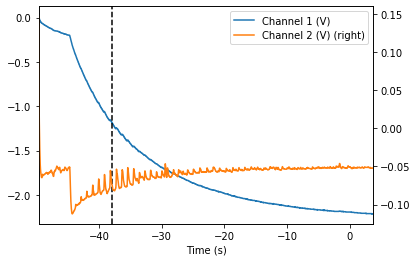

In [29]:
raw_data = pd.read_csv('data/hb-wesley.csv')
ax = raw_data.plot(x='Time (s)', y=['Channel 1 (V)', 'Channel 2 (V)'], secondary_y=['Channel 2 (V)'])

time_max = -38
ax.axvline(time_max, color='k', linestyle='--')

## Data Analysis

Figure 2 in the [pressure sensor datasheet](http://cache.freescale.com/files/sensors/doc/data_sheet/MPX5050.pdf) shows the transfer function from voltage to pressure in kPa and defines it as:

$$ V_{out} = V_S * (0.018 * P + 0.04) $$
$$ P = 55.56 * {V_{out} \over V_S} - 2.22 $$

In [40]:
v_source = 5  # V
pressure_v = raw_data.loc[raw_data['Time (s)'].round(2) == time_max, 'Channel 1 (V)'].iloc[0] + 2.5
pressure_kpa = 55.56 * pressure_v / v_source - 2.22
pressure_mmhg = pressure_kpa * 7.5

print("Mean blood pressure: {} mm Hg".format(pressure_mmhg))

Mean blood pressure: 93.43120541836177 mm Hg


## Circuit Analysis


In [43]:
bode_data = [
    [0.1, 0.101, 0.010],
    [0.2, 0.101, 0.030],
    [0.5, 0.101, 0.070], 
    [  1, 0.101, 0.111],
    [  2, 0.101, 0.134],
    [  5, 0.101, 0.131],
    [ 10, 0.101, 0.100],
    [ 50, 0.101, 0.010],
    [100, 0.102, 0.002]
]

bode_data_df = pd.DataFrame(bode_data)
bode_data_df.columns = ['Frequency', 'RawAmplitude', 'FilteredAmplitude']

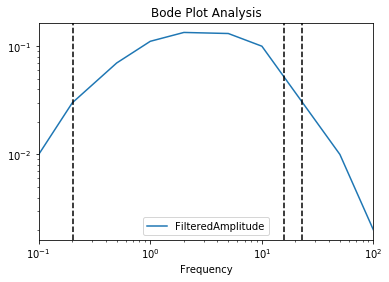

In [52]:
ax = bode_data_df.plot(x='Frequency', y=['FilteredAmplitude'], loglog=True)
ax.set_title("Bode Plot Analysis")

cutoff_frequencies = [0.201, 15.9, 22.7]
for i in cutoff_frequencies:
    ax.axvline(i, color='k', linestyle='--')

The bode plot shows the steep drop offs in amplitude both before the high pass filter cutoff frequency (0.201 Hz), and after the two low pass filter cutoff frequencies (15.9 Hz, 22.7 Hz). There is a higher dropoff rate past the second low pass filter because this starts acting as a second-order filter when the frequency is higher than 22.7 Hz. As a second order filter, the amplitude dampening is multiplied, so it decreases proportionally to the square of the frequency.